#Recurrent Neural Network (Time Series)

Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Download Data
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: /content/london_bike_sharing.csv
100% 1.03M/1.03M [00:00<00:00, 65.9MB/s]


In [ ]:
#Membaca Data
df = pd.read_csv(
  "london_bike_sharing.csv",
  parse_dates=['timestamp']
)
df.head(4)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0


1. "timestamp" - timestamp field for grouping the data
1. "cnt" - the count of a new bike shares
1. "t1" - real temperature in C
1. "t2" - temperature in C "feels like"
1. "hum" - humidity in percentage
1. "windspeed" - wind speed in km/h
1. "weathercode" - category of the weather
1. "isholiday" - boolean field - 1 holiday / 0 non holiday
1. "isweekend" - boolean field - 1 if the day is weekend
1. "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

1. "weather_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [ ]:
df.shape

(17414, 10)

In [ ]:
#Menyimpan Tanggal
dates = pd.to_datetime(df['timestamp'])
dates

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [ ]:
df = df.set_index('timestamp')
df.head(4)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0


In [ ]:
df.shape

(17414, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [ ]:
df.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [ ]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


EDA

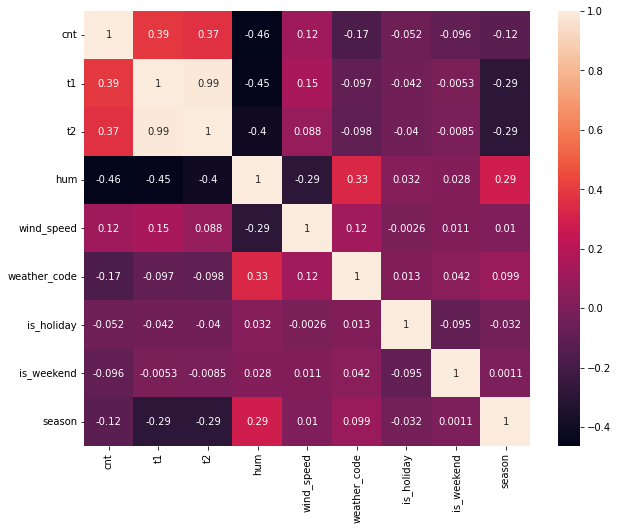

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

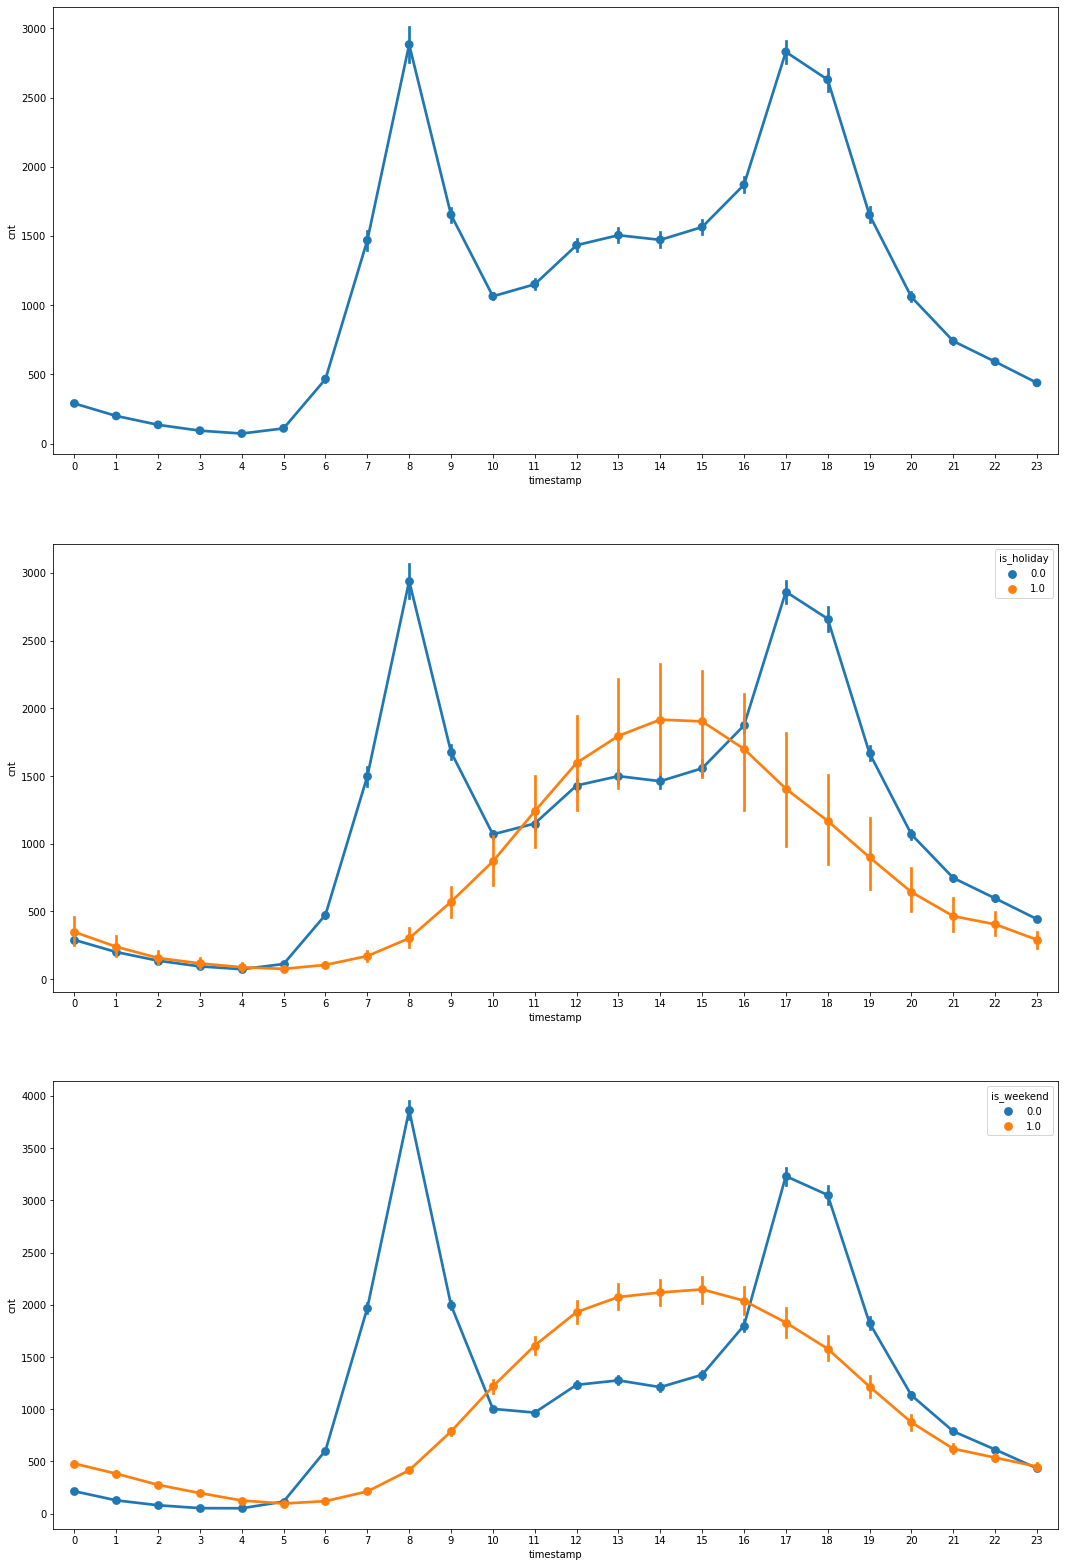

In [ ]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)

hour = df.index.hour
sns.pointplot(x=hour, y=df['cnt'], ax=ax1)
sns.pointplot(x=hour, y=df['cnt'], hue=df['is_holiday'], ax=ax2)
sns.pointplot(x=hour, y=df['cnt'], hue=df['is_weekend'], ax=ax3)

Preprocessing

In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


In [ ]:
from sklearn.preprocessing import MinMaxScaler

kolom = ['t1', 't2', 'hum', 'wind_speed']

x_scale = MinMaxScaler()
y_scale = MinMaxScaler()

x_scale = x_scale.fit(train[kolom])
y_scale = y_scale.fit(train[['cnt']])

train.loc[:,kolom] = x_scale.transform(train[kolom])
train['cnt'] = y_scale.transform(train[['cnt']])

test.loc[:,kolom] = x_scale.transform(test[kolom])
test['cnt'] = y_scale.transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
train.head(4)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,0.023155,0.126761,0.2000,0.911950,0.106195,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,0.017557,0.126761,0.2125,0.911950,0.088496,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,0.017048,0.112676,0.2125,0.955975,0.000000,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,0.009160,0.098592,0.2000,1.000000,0.000000,1.0,0.0,1.0,3.0


In [ ]:
train.shape

(15672, 9)

(samples, features) -> (samples, timestep, features)

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 10

X_train, y_train = create_dataset(train, train['cnt'], time_steps)
X_test, y_test = create_dataset(test, test['cnt'], time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15662, 10, 9) (15662,)
(1732, 10, 9) (1732,)


Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(64, activation='relu',
               input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            18944     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                     patience=3)

In [ ]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[callback],
                    shuffle=False)

Epoch 1/500
441/441 [==============================] - 9s 14ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 2/500
441/441 [==============================] - 6s 14ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 3/500
441/441 [==============================] - 6s 14ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 4/500
441/441 [==============================] - 6s 14ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 5/500
441/441 [==============================] - 6s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/500
441/441 [==============================] - 6s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/500
441/441 [==============================] - 6s 13ms/step - loss: 9.8667e-04 - val_loss: 0.0010
Epoch 8/500
441/441 [==============================] - 6s 13ms/step - loss: 9.0016e-04 - val_loss: 0.0011
Epoch 9/500
441/441 [==============================] - 6s 13ms/step - loss: 8.4360e-04 - val_loss: 0.0011
Epoch 10/500
441/441 [==============================] - 6s 13ms/step -

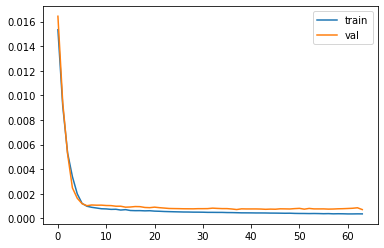

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()
plt.show()

Prediksi

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred[0:5]

array([[0.19609903],
       [0.12962396],
       [0.08647982],
       [0.06565774],
       [0.04790283]], dtype=float32)

In [ ]:
y_pred_inv = y_scale.inverse_transform(y_pred)
y_test_inv = y_scale.inverse_transform(y_test.reshape(1, -1))

In [ ]:
print(y_pred_inv[:5].flatten())
print(y_test_inv[:5])

[1541.3384  1018.84436  679.7314   516.0698   376.51624]
[[1376.  894.  615. ...  337.  224.  139.]]


In [ ]:
y_pred_inv = y_pred_inv.astype('int64')
y_test_inv = y_test_inv.astype('int64')

In [ ]:
print(y_pred_inv[:5].flatten())
print(y_test_inv[:5])

[1541 1018  679  516  376]
[[1376  894  615 ...  337  224  139]]


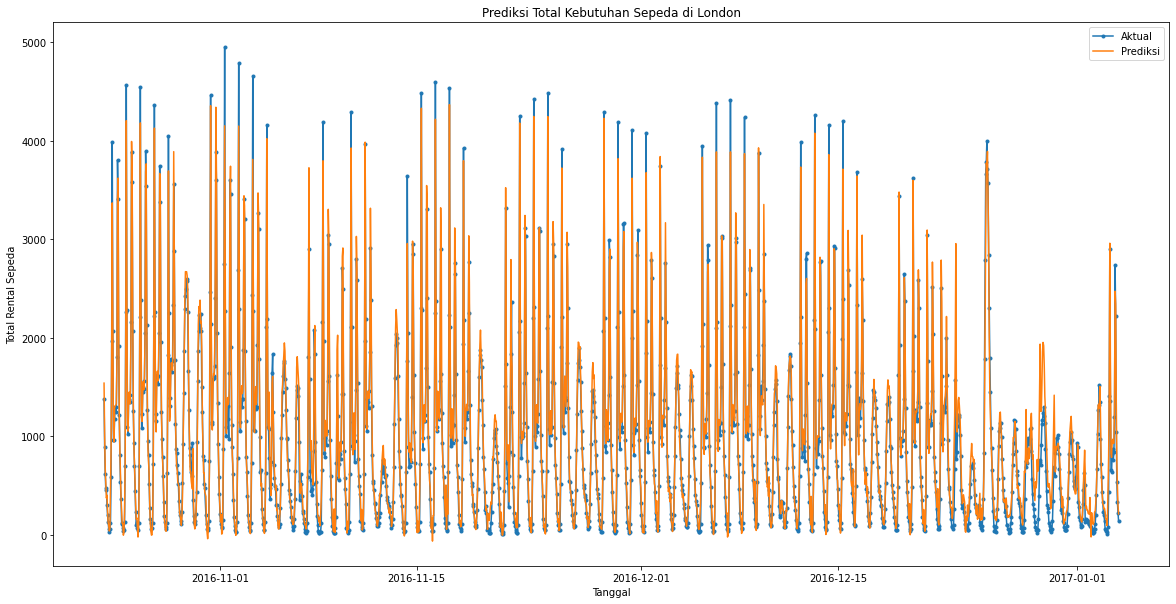

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dates[-X_test.shape[0]:], y_test_inv.flatten(), marker='.', label="Aktual")
plt.plot(dates[-X_test.shape[0]:], y_pred_inv.flatten(), label="Prediksi")
plt.ylabel('Total Rental Sepeda')
plt.xlabel('Tanggal')
plt.title('Prediksi Total Kebutuhan Sepeda di London')
plt.legend()
plt.show()

In [ ]:
df_forecast = pd.DataFrame({
    'Date' : dates[-X_test.shape[0]:],
    'Bike Count' : y_pred_inv.flatten()
    })

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

x = y_test_inv.flatten()
y = df_forecast['Bike Count'].values

mse = mean_squared_error(x,y)
rmse = mean_squared_error(x,y,squared=False) #RMSE
mae = mean_absolute_error(x,y)
mape = mean_absolute_percentage_error(x,y)
nilai_r = r2_score(x,y)

print('Nilai Mean Squared Error             = {:.2f}'.format(mse))
print('Nilai Root Mean Squared Error        = {:.2f}'.format(rmse))
print('Nilai Mean Absolute Error            = {:.2f}'.format(mae))
print('Nilai Mean Absolute Percentage Error = {:.2f}'.format(mape))
print('Nilai R2                             = {:.2f}'.format(nilai_r))

Nilai Mean Squared Error             = 33636.01
Nilai Root Mean Squared Error        = 183.40
Nilai Mean Absolute Error            = 121.58
Nilai Mean Absolute Percentage Error = 0.48
Nilai R2                             = 0.96


In [ ]:
df_forecast.to_csv('/content/Hasil Prediksi.csv')